# This notebook showcases the beamconv HWP class
We start by importing the relevant libraries and items

In [1]:
import os, pickle, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from beamconv import ScanStrategy, Beam, tools
import qpoint as qp
import seaborn as sns
sns.set()
%matplotlib inline

First, we define a beam. Notice there are two attributes starting with hwp: the class proper, and the precomputed Mueller matrix parameters $T, \rho, c, s$. By default, the $\tt hwp\_precomp\_mueller$, and the HWP class' only attribute, $\tt stack$, are set to $\tt None$

In [2]:
beamy = Beam(name='beamy', sensitive_freq=2.8e11) 

In [3]:
print beamy
print beamy.hwp
print beamy.hwp.stack
print beamy.hwp_precomp_mueller

name    : beamy 
btype   : Gaussian 
alive   : True 
FWHM    : 43.2 arcmin 
az      : 0.0 deg 
el      : 0.0 deg 
polang  : 0.0 deg
po_file : None 

None
None


We assign a stack to hwp from one of our predefined models (there are five, see the source code for their names and characteristics). Stacks are made of slices of specific thickness, with a name, a type (isotropic or uniaxial), and index/indices (if the material is uniaxial) and losses (the imaginary part of the index). The slices are supposed to extend to infinity in the xy plane, and be stacked in the z axis.

In [4]:
beamy.hwp._choose_HWP_model(model_name='SPIDER')
print beamy.hwp.stack



______________________________________________________


Layer 1: Thickness 0.000427


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.004930


Material: Sapphire
Material Type: uniaxial
Refractive Index (ordinary): 3.070000
Refractive Index (extraordinary): 3.410000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 3: Thickness 0.000427


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.951000
Loss tangent: 0.001200


______________________________________________________



We can then call the hwp method $\tt \_compute4params$ for a particular frequency and angle of incidence to calculate the $\tt hwp\_precomp\_mueller$ for that particular beam.

In [5]:
beamy.hwp_precomp_mueller = beamy.hwp._compute4params(freq=1e11, alpha= 0.01)
print beamy.hwp_precomp_mueller

[ 0.9275709   0.01493953 -0.9355145  -0.35297227]


We can also create our own material stack, by supplying $\tt \_stack\_builder$ with its own layers. Layers will be named by a number. 'angles' corresponds to the rotation of the slice around the z-axis (with angles=0 for the extraordinary axis along x), we usually set it to be zero. Note that we now compute the Muelller parameters using the elevation and the sensitive frequency of the beam !

In [6]:
thicknesses=np.array([4.3])
indices = np.array([[1.,1.]])
losses = np.array([[0.,0.]])
angles = np.array([0.])
beamy.hwp._stack_builder(thicknesses=thicknesses, indices=indices, losses=losses, angles=angles)
print beamy.hwp.stack
beamy.hwp_precomp_mueller = beamy.hwp._compute4params(freq=beamy.sensitive_freq, alpha= np.radians(beamy.el))
print beamy.hwp_precomp_mueller



______________________________________________________


Layer 1: Thickness 0.004300


Material: 0
Material Type: isotropic
Refractive Index: 1.000000
Loss tangent: 0.000000


______________________________________________________

[1. 0. 1. 0.]


$\tt Beam$ also has a function that defines the stack and computes the parameters in one go. I would recommend using it instead of the other two

In [7]:
beamy._set_HWP_values(model_name='Ar+HWP+Ar', thicknesses=None, indices=None, losses=None, angles=None)
print beamy.hwp.stack
print beamy.hwp_precomp_mueller



______________________________________________________


Layer 1: Thickness 0.000305


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.715000
Loss tangent: 0.001200


______________________________________________________

Layer 2: Thickness 0.003150


Material: Sapphire
Material Type: uniaxial
Refractive Index (ordinary): 3.070000
Refractive Index (extraordinary): 3.410000
Loss Tangent (ordinary): 0.000230
Loss Tangent (extraordinary): 0.000125


	 Angle of extraordinary axis to x-axis: 0.000000
______________________________________________________

Layer 3: Thickness 0.000305


Material: RT Duroid
Material Type: isotropic
Refractive Index: 1.715000
Loss tangent: 0.001200


______________________________________________________

[ 0.9326036  -0.00421984  0.99947879  0.03200518]


We generate some set of HWP angles $\theta$ and boresight angles $\psi$. We then call the $\tt \_get\_Mueller\_top\_row $ method of the beam to get the values of the top-row elements of the complete Mueller matrix. $\xi$ is the detector's angle.

In [8]:
theta = np.pi*np.arange(0,2, 0.01)
psi = np.zeros(theta.size)
M_II, M_IP, M_IP_bar = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)

This works even if the $\tt precomp\_mueller$ has not be calculated, as the method will evaluate it from the $\tt hwp.stack$ if there is none yet. It will only do so once for the beam's lifetime, which increases performance.

In [9]:
beamy.hwp_precomp_mueller=None
beamy.hwp._choose_HWP_model(model_name='HWP_only')
M_II, M_IP, M_IP_bar = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)

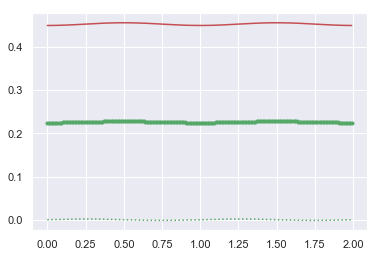

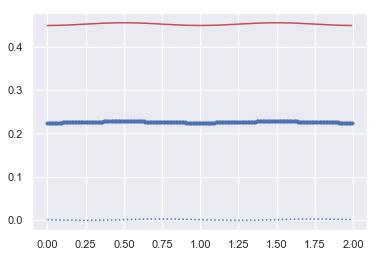

In [10]:
plt.figure(1)
mip_plot = plt.plot(theta/np.pi, M_II, 'r', theta/np.pi, np.real(M_IP), 'g.', 
                    theta/np.pi, np.imag(M_IP), 'g:')
plt.figure(2)
mipbar_plot = plt.plot(theta/np.pi, M_II, 'r', theta/np.pi, np.real(M_IP_bar), 'b.', 
                     theta/np.pi, np.imag(M_IP_bar), 'b:')

We want to estimate the gain of varous HWPs, as a function of beam frequency and angle of incidence

In [ ]:
elevations = np.arange(0,90,1)
frequencies = np.arange(50e9, 300e9, 1e9)
Mis = np.zeros((elevations.size, frequencies.size,4))
Mip = np.zeros((elevations.size,frequencies.size,4), dtype=np.complex128)
Mipbar = np.zeros((elevations.size,frequencies.size,4), dtype=np.complex128)
theta = 0
psi = 0
for i in range (elevations.size):
    beamy.el = elevations[i]
    for j in range(frequencies.size):
        beamy.sensitive_freq = frequencies[j]
        beamy._set_HWP_values(model_name='HWP_only')
        Mis[i,j,0], Mip[i,j,0], Mipbar[i,j,0] = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy._set_HWP_values(model_name='Ar+HWP+Ar')
        Mis[i,j,1], Mip[i,j,1], Mipbar[i,j,1] = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy._set_HWP_values(model_name='Ar1+Ar2+HWP+Ar2+Ar1')
        Mis[i,j,2], Mip[i,j,2], Mipbar[i,j,2] = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)
        beamy._set_HWP_values(model_name='SPIDER')
        Mis[i,j,3], Mip[i,j,3], Mipbar[i,j,3] = beamy._get_Mueller_top_row(xi=0.0, psi=psi, theta=theta)



In [ ]:
a =plt.figure(1)
HWP_only=plt.plot(elevations, Mis[:,0,0]/.5, label='HWP_only')
ARHWP = plt.plot(elevations, Mis[:,0,1]/.5, label = 'Ar+HWP+Ar')
DoubleAR = plt.plot(elevations, Mis[:,0,2]/.5, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
SpiderHWP = plt.plot(elevations, Mis[:,0,3]/.5, label='SPIDER HWP')
plt.xlabel('elevation angle (degrees)')
plt.ylabel(r'$M_{II}/M_{II \: ideal}$')
plt.legend()
b =plt.figure(2)
plt.plot(elevations, np.real(Mip)[:,0,0]/.25, label='HWP_only')
plt.plot(elevations, np.real(Mip)[:,0,1]/.25, label = 'Ar+HWP+Ar') 
plt.plot(elevations, np.real(Mip)[:,0,2]/.25, label = 'Ar1+Ar2+HWP+Ar2+Ar1')
plt.plot(elevations, np.real(Mip)[:,0,3]/.25, label='SPIDER HWP')
plt.xlabel('elevation angle (degrees)')
plt.ylabel(r'$M_{IP}/M_{IP \: ideal}$')
plt.legend()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(30,15))
axes[0,0].set_xlabel('Frequency (GHz)')
axes[0,0].set_ylabel(r'Beam elevation ($\:^\circ$)')
axes[0,0].set_title('HWP only')
axes[0,1].set_xlabel('Frequency (GHz)')
axes[0,1].set_ylabel(r'Beam elevation ($\:^\circ$)')
axes[0,1].set_title('Ar+HWP+Ar')
axes[1,0].set_xlabel('Frequency (GHz)')
axes[1,0].set_ylabel(r'Beam elevation ($\:^\circ$)')
axes[1,0].set_title('Ar1+Ar2+HWP+Ar2+Ar1')
axes[1,1].set_xlabel('Frequency (GHz)')
axes[1,1].set_ylabel(r'Beam elevation ($\:^\circ$)')
axes[1,1].set_title('SPIDER HWP')
ul = axes[0,0].contourf(frequencies/1e9,elevations,Mis[:,:,0]/.5,10)
plt.colorbar(ul, ax=axes[0,0])
ur = axes[0,1].contourf(frequencies/1e9,elevations,Mis[:,:,1]/.5,10)
plt.colorbar(ur, ax=axes[0,1])
ll = axes[1,0].contourf(frequencies/1e9,elevations,Mis[:,:,2]/.5,10)
plt.colorbar(ll, ax=axes[1,0])
lr = axes[1,1].contourf(frequencies/1e9,elevations,Mis[:,:,3]/.5,10)
plt.colorbar(lr, ax=axes[1,1])